# Time Series Illustration: Monthly Sales of Champagne Data: XGboost



In [1]:

### Just to remove warnings to prettify the notebook.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the series without 'squeeze' parameter
series = pd.read_csv('international-airline-passengers.csv')

# Check for NaN values in the dataset
nan_values = series.isna().sum()

# Output the result
print(nan_values)

Month                                                                             0
International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60    1
dtype: int64


In [4]:
# Remove rows with NaN values
series = series.dropna()

# Rename the column to 'Passengers'
series.rename(columns=lambda x: x.strip(), inplace=True)  # This removes extra spaces if present
series.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'Passengers'}, inplace=True)

# Output the cleaned dataset
print(series)

       Month  Passengers
0    1949-01       112.0
1    1949-02       118.0
2    1949-03       132.0
3    1949-04       129.0
4    1949-05       121.0
..       ...         ...
139  1960-08       606.0
140  1960-09       508.0
141  1960-10       461.0
142  1960-11       390.0
143  1960-12       432.0

[144 rows x 2 columns]


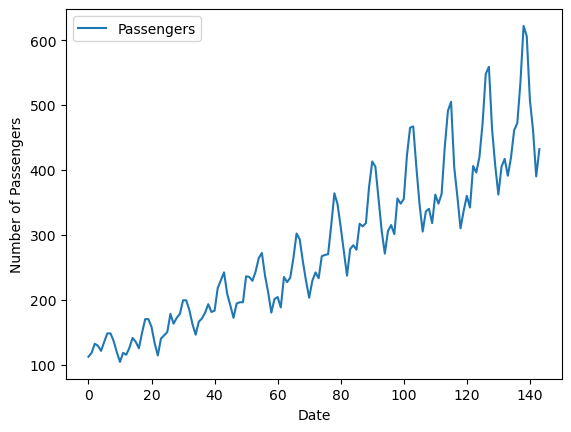

In [5]:
import pandas as pd
from matplotlib import pyplot as plt

# Plot the series with explicit label and legend enabled
series.plot()
plt.ylabel('Number of Passengers')
plt.xlabel('Date')
plt.show()

In [24]:
import numpy as np
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Load the dataset,
series = pd.read_csv('dataset.csv', header=0, usecols=[0, 1], names=['Date', 'Passengers'], parse_dates=[0], index_col=0)

# Fix frequency issue by explicitly setting it to a monthly frequency
if not series.index.freq:
    series.index = pd.date_range(start=series.index[0], periods=len(series), freq='MS')  # Monthly Start frequency

# Define a 1-year forecast period (12 months)
forecast_horizon = 12

# Prepare the dataset for supervised learning (for XGBoost)
def create_features(df, label=None):
    df['date'] = df.index
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    X = df[['year', 'month', 'dayofyear', 'dayofweek', 'quarter']]
    if label:
        y = df[label]
        return X, y
    return X

# Use the entire dataset minus the last 12 months for training, and forecast the last 12 months
train_size = len(series) - forecast_horizon
train, forecast_period = series[:train_size], series[train_size:]

# Create features for training and forecasting
X_train, y_train = create_features(train, label='Passengers')
X_forecast = create_features(forecast_period)

# GridSearchCV to find the optimal XGBoost model
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_model = XGBRegressor()

# Use TimeSeriesSplit for time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters from the GridSearch
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the optimal XGBoost model
optimal_xgb = XGBRegressor(**best_params)
optimal_xgb.fit(X_train, y_train)

# Predict the forecast period (last 12 months)
xgboost_forecast = optimal_xgb.predict(X_forecast[:forecast_horizon])

# Print the forecast results
print(f"XGBoost forecast for the next 12 months: {xgboost_forecast}")

# Compute RMSE and R² score
y_true = forecast_period['Passengers'].values  # Actual passenger values for the forecast period
rmse = np.sqrt(mean_squared_error(y_true, xgboost_forecast))
r2 = r2_score(y_true, xgboost_forecast)

# Print RMSE and R² score
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
XGBoost forecast for the next 12 months: [331.1328  331.98862 316.38168 363.13153 363.08066 364.22638 433.58597
 493.4224  493.81952 407.1298  352.22168 303.20886]
RMSE: 46.35805901766825
R² Score: 0.5775830627463416


# Compare with plot of Notebook 1 using ARIMA for the time series forecast.

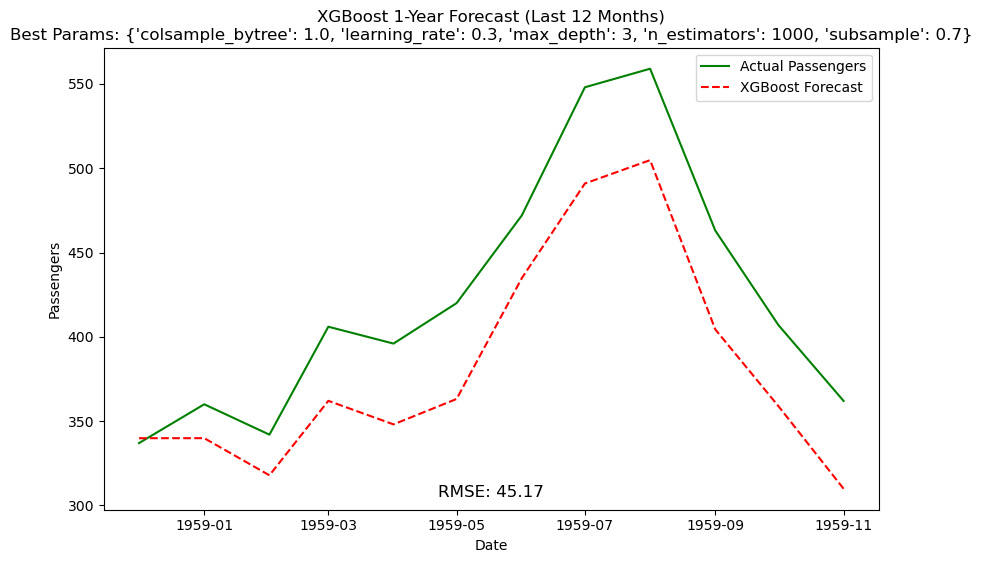

RMSE for XGBoost 1-Year Forecast: 45.17153829437039


In [23]:
# Plot the forecast results for the test set (actual sales vs. forecast)
plt.figure(figsize=(10, 6))

# Plot the actual sales data for the forecast period (last 12 months) in green.
plt.plot(forecast_period.index[:forecast_horizon], forecast_period['Passengers'][:forecast_horizon], label='Actual Passengers', color='green')

# Plot the XGBoost forecasted sales data for the same 12-month period in red with a dashed line.
plt.plot(forecast_period.index[:forecast_horizon], xgboost_forecast, label='XGBoost Forecast', linestyle='--', color='red')

# Set the x-axis label to "Date" and the y-axis label to "Sales".
plt.xlabel('Date')
plt.ylabel('Passengers')

# Add a plot title, mentioning the XGBoost forecast for the last 12 months and showing the best parameters used in the model.
plt.title(f'XGBoost 1-Year Forecast (Last 12 Months)\nBest Params: {best_params}')

# Add a legend to differentiate between actual sales and forecasted sales.
plt.legend()

# Display RMSE on the plot
rmse = np.sqrt(mean_squared_error(forecast_period['Passengers'][:forecast_horizon], xgboost_forecast))
plt.text(0.5, 0.02, f'RMSE: {rmse:.2f}', horizontalalignment='center', verticalalignment='bottom', transform=plt.gca().transAxes, fontsize=12)

plt.show()

# Print RMSE
print(f"RMSE for XGBoost 1-Year Forecast: {rmse}")

In this case, the result from ARIMA with RMSE of **21.656** outperforms the XGBoost with RMSE of **45.172**.

RMSE for rolling forecast: 34.52595767395041


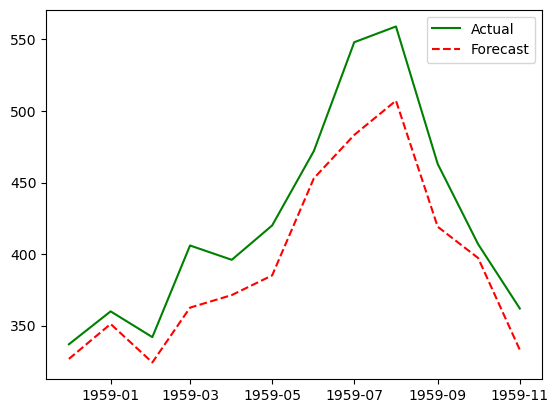

In [34]:
import numpy as np
import pandas as pd
from pandas import read_csv
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
series = pd.read_csv('dataset.csv', header=0, usecols=[0, 1], names=['Date', 'Passengers'], parse_dates=[0], index_col=0)

# Fix frequency issue by explicitly setting it
if not series.index.freq:
    series.index = pd.date_range(start=series.index[0], periods=len(series), freq='MS')  # Monthly frequency

# Define 1-year forecast period (12 months)
forecast_horizon = 12
window_size = 12

# Function to create lagged features (12 previous months)
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i].values)  # Previous 12 months
        y.append(data[i])  # Next month's value (target)
    return np.array(X), np.array(y)

# Function to run the rolling forecast with a 12-month lagged window
def rolling_forecast_lagged(series, forecast_horizon, window_size=12):
    train_size = len(series) - forecast_horizon
    train, test = series[:train_size], series[train_size:]

    predictions = []

    # Convert the training data to lagged features
    X_train, y_train = create_lagged_features(train['Passengers'], window_size)

    for i in range(forecast_horizon):
        # Create feature for the next point to forecast using the last 12 months
        X_next = series['Passengers'][train_size-window_size+i:train_size+i].values.reshape(1, -1)

        # Initialize XGBoost model
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.3, max_depth=3, subsample=0.7, colsample_bytree=0.7)

        # Train the model
        xgb_model.fit(X_train, y_train)

        # Forecast the next point
        next_forecast = xgb_model.predict(X_next)
        predictions.append(next_forecast[0])

        # Update training set with actual observed value after the forecast
        X_train = np.vstack([X_train, X_next])
        y_train = np.append(y_train, test['Passengers'].iloc[i])

    return predictions, test['Passengers']

# Perform rolling forecast
xgboost_forecast, actuals = rolling_forecast_lagged(series, forecast_horizon)

# Calculate RMSE for the rolling forecast
rmse = np.sqrt(mean_squared_error(actuals, xgboost_forecast))
print(f"RMSE for rolling forecast: {rmse}")

# Plot the results
plt.plot(series.index[-forecast_horizon:], actuals, label='Actual', color='green')
plt.plot(series.index[-forecast_horizon:], xgboost_forecast, label='Forecast',linestyle='--', color='red')
plt.legend()
plt.show()

Using a window size lag of **12**, XGBoost performs better with RMSE of **34.526** compare to the original XGBoost with RMSE of **45.172**. Hence, the ARIMA still outperforms the XGBoost.